### Материалы

1. Презентация: https://mega.nz/file/4JMxmQQa#r1FTUl2Msak7de3Q6En8Zcje6LMuSlp1iaiIAXwt50Y
2. Дашборд: https://public.tableau.com/views/Space_brothers_16525259773400/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link

# "Космические братья" - формирование модели монетизации

**Оглавление**
1. [Задачи проекта](#Задачи-проекта)
2. [Загрузка файлов с данными и изучение общей информации о них](#Загрузка-и-обзор-данных)
3. [Подготовка данных](#Подготовка-данных)
4. [Исследовательский анализ данных](#Исследовательский-анализ-данных)
5. [Проверка гипотез](#Проверка-гипотез)
6. [Описание и оценка модели монетизации](#Описание-и-оценка-модели-монетизации)
7. [Общий вывод](#Общий-вывод)

## Задачи проекта

Основная задача проекта - сформировать модель монетизации игрового приложения.

Необходимо выбрать оптимальное время для запуска рекламы. С учётом расходов на продвижение игры, рассчитать её окупаемость при разных сценариях.

В рамках выполнения обозначенных задач:
1. Проведём исследовательский анализ данных.
2. Проанализируем влияние событий на совершение целевого события.
3. Проверим статистические гипотезы (различия времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком, другие релевантные гипотезы).

Зафиксируем следующее:
* Целевым событием является завершение первого уровня;
* Прибыль от одного показа рекламы составляет 0.07 условных единиц.

## Загрузка и обзор данных

Всего в проекте представлены три набора данных.

Основной датасет содержит данные о событиях, совершенных в мобильной игре «Космические братья». В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики.
Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

В датасете представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:
1. Победа над первым врагом
2. Реализация проекта - разработка орбитальной сборки спутников

В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

Датасет `game_actions.csv`:
* `event_datetime` — время события;
* `event` — одно из трёх событий:
    1. `building` — объект построен,
    2. `finished_stage_1` — первый уровень завершён,
    3. `project` — проект завершён;
* `building_type` — один из трёх типов здания:
    1. `assembly_shop` — сборочный цех,
    2. `spaceport` — космопорт,
    3. `research_center` — исследовательский центр;
* `user_id` — идентификатор пользователя;
* `project_type` — тип реализованного проекта;

Помимо основного датасета есть два датасета с информацией о рекламных активностях. Они также помогут в решении задачи.

Датасет `ad_cost.csv` содержит колонки:
* `day` - день, в который был совершен клик по объявлению
* `source` - источник трафика
* `cost` - стоимость кликов

Датасет `user_source.csv` содержит колонки:
* `user_id` - идентификатор пользователя
* `source` - источников, с которого пришёл пользователь, установивший приложение

In [1]:
# Подключение библиотек для анализа
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
try:
    game_actions = pd.read_csv('/datasets/game_actions.csv')
    ad_cost = pd.read_csv('/datasets/ad_costs.csv')
    user_source = pd.read_csv('/datasets/user_source.csv')
except:
    game_actions = pd.read_csv(input('Введите путь к файлу game_actions.csv: '))
    ad_cost = pd.read_csv(input('Введите путь к файлу ad_cost.csv: '))
    user_source = pd.read_csv(input('Введите путь к файлу user_source.csv: '))

In [3]:
# Т.к. датасета 3 - пробежимся по ним циклом.
for key, value in {'game_actions': game_actions, 'ad_cost': ad_cost, 'user_source': user_source}.items():
    print(f"Обзор набора данных {key}", end='\n\n')
    value.info()
    display(value.head())
    print("=" * 25, end='\n\n')

Обзор набора данных game_actions

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN



Обзор набора данных ad_cost

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796



Обзор набора данных user_source

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


### Промежуточный вывод

* В наборе данных с игровыми действиями ~136 000 записей. В полях с датой, типом события и пользовательским ID пропусков нет, однако они присутствуют в типе постройки (в незначительном количестве) и типе проекта (большинство записей не являются записями о проекте).

* В наборе данных со стоимостью привлечения пользователей - 28 (7 дней и, предположительно, 4 источника) записей о стоимости, дне привлечения и источнике, пропусков не обнаружено.

* В наборе данных о конкретном источнике привлечения пользователей 13 576 записей. Пропусков не обнаружено.

Можно перейти к этапу подготовки данных.

## Подготовка данных

Этап подготовки данных традиционно включает в себя следующие шаги:

* Замена названий столбцов (приведение к нижнему регистру);
* Преобразование данных в нужные типы;
* Обработка пропусков:
    - Заполнение / отказ от заполнения пропусков с объяснением причин;
    - Анализ возможных причин появления пропусков.
* Обработка дубликатов.

Ни в одном из представленных наборов данных нет необходимости производить замену названий столбцов.
Столбцы `event_datetime` и `day` в наборах данных `game_actions` и `ad_costs` соответственно преобразуем в `datetime`, после чего займёмся обработкой пропусков.

In [4]:
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'])
ad_cost['day'] = pd.to_datetime(ad_cost['day'])

На этапе загрузки и ознакомления с данными обнаружили пропуски в двух столбцах набора данных `game_actions`: `building_type` и `project_type`.
Теоретически, пропуски должны объясняться записями в `event`. Проверим эту догадку.

In [5]:
# Проверка пропусков в building_type
display(game_actions[game_actions['building_type'].isna()]['event'].value_counts())

# Проверка пропусков в project_type
display(game_actions[game_actions['project_type'].isna()]['event'].value_counts())

finished_stage_1    5817
project             1866
Name: event, dtype: int64

building            127957
finished_stage_1      5817
Name: event, dtype: int64

В обоих случаях видим, что пропускам в переменной соответствуют объясняющие её типы событий - окончание первого этапа и проект / постройка для типа постройки / типа проекта соответственно. Так как все рассматриваемые переменные - категориальные, пропуски можно не заполнять. Сами по себе они могут выступать удобным фильтром.

Выполним проверку на существование дубликатов в предоставленных записях.

In [6]:
for df in (game_actions, ad_cost, user_source):
    display(df[df.duplicated()])

,event_datetime,event,building_type,user_id,project_type
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN


,source,day,cost


,user_id,source


Во всей базе обнаружен один полный дубликат - в информации о пользовательских действиях. Избавимся от него, после чего можем перейти к исследовательскому анализу данных.

In [7]:
game_actions = game_actions.drop_duplicates()

## Исследовательский анализ данных

В рамках исследовательского анализа данныз оценим следующие показатели:

* Количество пользователей по дням;
* Количество совершённых действий по дням;
* Общий отток пользователей;
* Доля пользователей, совершивших целевое действие (перешли на следующий уровень);
* Доли PvE и PvP-ориентированных игроков.

In [8]:
# Расчёт количества активных пользователей и числа действий, ими совершённых

game_actions.set_index('event_datetime') \
    .pivot_table(index=pd.Grouper(freq='d'), 
                 values=['user_id', 'event'], 
                 aggfunc={'user_id':pd.Series.nunique, 'event':'count'}) \
    .rename(columns={'event':'count_actions', 'user_id':'unique_users'})

,count_actions,unique_users
event_datetime,,
2020-05-04,8171,5860
2020-05-05,9055,6382
2020-05-06,9925,6854
2020-05-07,10858,7384
2020-05-08,12059,7891
2020-05-09,13129,8394
2020-05-10,15207,9219
2020-05-11,8185,5995
2020-05-12,7918,5776


Число пользователей и совершаемых ими действий достигает максимума 10 мая - в последний день рекламной кампании, после чего одномоментно резко снижается и продолжает снижаться вплоть до конца доступного для анализа периода - на графике ниже также показаны оба показателя.

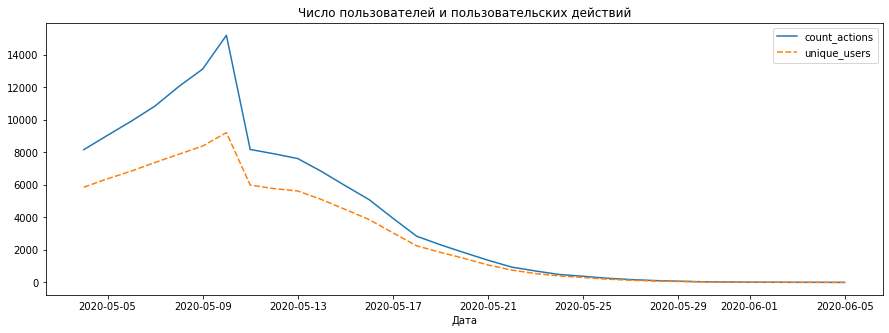

In [9]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=game_actions.set_index('event_datetime') \
    .pivot_table(index=pd.Grouper(freq='d'), 
                 values=['user_id', 'event'], 
                 aggfunc={'user_id':pd.Series.nunique, 'event':'count'}) \
    .rename(columns={'event':'count_actions', 'user_id':'unique_users'}))
plt.title('Число пользователей и пользовательских действий')
plt.xlabel('Дата');

Оценим число пользователей, совершивших целевое действие, и общий отток пользователей - в целях нашего анализа будем считать "потеряным" пользователя, НЕ совершившего целевого действия.

In [10]:
target = game_actions[game_actions['event']=='finished_stage_1']['user_id'].nunique()
total = game_actions['user_id'].nunique()

print(f"Совершили целевое действие {target} пользователей, что составляет {target / total * 100:.1f}% от всех.\nОтток составил {total - target} пользователей.")

Совершили целевое действие 5817 пользователей, что составляет 42.8% от всех.
Отток составил 7759 пользователей.


Менее половины пользователей совершили целевое действие. В отсутствие базы для сравнения нельзя сделать вывод, насколько хорош этот показатель, поэтому пока просто его зафиксируем.

Среди совершивших целевое действие оценим доли PvE и PvP-ориентированных игроков. Так как в логах нет информации о сражениях, будем считать, что выполненное пользователем целевое действие "завершение первого уровня" без записи о реализации проекта является маркером PvP-ориентированности игрока.

In [11]:
completers = game_actions[game_actions['event'] == 'finished_stage_1']['user_id'].drop_duplicates()
pve_completers = game_actions[game_actions['event'] == 'project']['user_id'].drop_duplicates()
pvp_completers = completers[~completers.isin(pve_completers)]

print(f"Доля PvE-игроков: {len(pve_completers) / len(completers) * 100:.1f}%\nДоля PvP-игроков: {len(pvp_completers) / len(completers) * 100:.1f}%")

Доля PvE-игроков: 32.1%
Доля PvP-игроков: 67.9%


Игроков, перешедших на следующий уровень за счёт победы над другим игроком - около 2/3 от всех, совершивших действие. Кажется, нам нужно задуматься о введении в сюжет игры Каина и Авеля.

Для того, чтобы дальнейшие шаги выполнялись эффективнее, создадим отдельный датафрейм с пользовательской информацией: помимо источника привлечения, зафиксируем стоимость его привлечения, дату регистрации (первого совершённого действия), флаг и дату завершения первого уровня, а также характеристику стиля игры (PvE, PvP, undefined для тех, пользователей, определить стиль которых невозможно).

Кроме того, необходимо проанализировать и два других доступных набора данных, чтобы получить понимание об эффективности маркетинговых расходов.

In [12]:
# копируем датафрейм с источником для каждого пользоователя
users = user_source

# добавляем пользователю дату регистрации
users = users.merge(pd.Series(game_actions.groupby('user_id')['event_datetime'].min() - pd.to_timedelta(1, unit='d')).dt.date.to_frame(), 
                    left_on = 'user_id', 
                    right_index = True).rename(columns={'event_datetime':'reg_date'})

users['reg_date'] = pd.to_datetime(users['reg_date'])

temp = users.pivot_table(index=['reg_date', 'source'], values='user_id', aggfunc='count').reset_index() \
    .merge(ad_cost, left_on=['reg_date', 'source'], right_on=['day', 'source'])

temp['per_user'] = temp['cost'] / temp['user_id']

users = users.merge(temp[['source', 'day', 'per_user']], 
                 left_on=['source', 'reg_date'], 
                 right_on=['source', 'day']).rename(columns={'per_user':'cost'})

# добавляем флаг прохождения первого уровня
users['target_achieved'] = users['user_id'].isin(completers)

# добавляем дату прохождения первого уровня
users = users.merge(game_actions[game_actions['event']=='finished_stage_1'][['user_id','event_datetime']], on = 'user_id', how = 'left').rename(columns={'event_datetime':'date_target'})

# добавляем стратегию
users['strategy'] = users.apply(lambda x: 'PvP' if x['user_id'] in list(pvp_completers) 
                                else 'PvE' if x['user_id'] in list(pve_completers) 
                                else 'undefined', axis=1)

# избавляемся от ненужных переменных и выводим получившийся датафрейм для обзора
users = users.drop(columns=['day'])
del temp

users

,user_id,source,reg_date,cost,target_achieved,date_target,strategy
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads,2020-05-05,0.754162,False,NaT,undefined
1,01303c2e-7de1-4742-8c3e-daf182b67b9f,facebook_ads,2020-05-05,0.754162,False,NaT,undefined
2,0136963c-c45c-4edb-92d8-205bd50a4d36,facebook_ads,2020-05-05,0.754162,True,2020-05-25 08:56:48,PvE
3,018793d6-38c8-450a-bd54-8c181d920f1a,facebook_ads,2020-05-05,0.754162,True,2020-05-24 23:52:53,PvE
4,01e2b256-4519-493f-b010-4a90a2755245,facebook_ads,2020-05-05,0.754162,False,NaT,undefined
...,...,...,...,...,...,...,...
13571,f904bb06-e8f9-4aef-8773-5a47f12ac103,yandex_direct,2020-05-07,0.478784,False,NaT,undefined
13572,fa1ffc17-0032-4b4d-ac0d-6c75b890db9e,yandex_direct,2020-05-07,0.478784,True,2020-05-24 12:50:48,PvE
13573,fd7d35ce-430b-40e0-a325-9d2b27b425e5,yandex_direct,2020-05-07,0.478784,True,2020-05-25 00:18:28,PvP
13574,fec9a806-0291-4d46-914b-e4dd14ad3864,yandex_direct,2020-05-07,0.478784,False,NaT,undefined


Собрали полный датафрейм с информацией о пользователях. Проведём также исследовательский анализ оставшихся датафреймов - `user_source` и `ad_cost`.

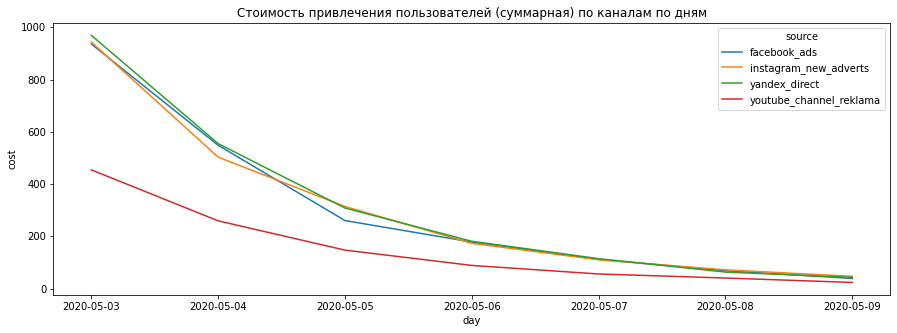

In [13]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=ad_cost, x='day', y='cost', hue='source')
plt.title('Стоимость привлечения пользователей (суммарная) по каналам по дням');

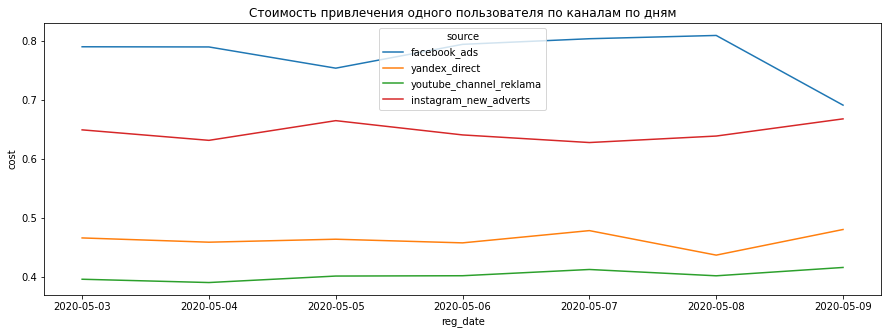

In [14]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=users[['reg_date', 'cost', 'source']].drop_duplicates(), x='reg_date', y='cost', hue='source')
plt.title('Стоимость привлечения одного пользователя по каналам по дням');

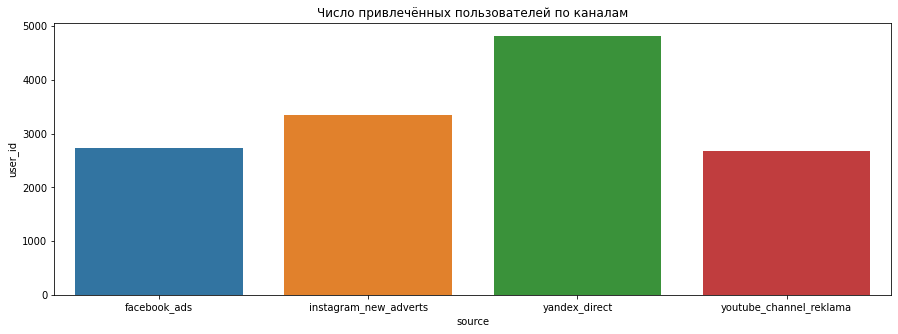

In [15]:
plt.figure(figsize=(15, 5))
sns.barplot(data=user_source.pivot_table(index='source', values='user_id', aggfunc='count').reset_index(), x='source', y='user_id')
plt.title('Число привлечённых пользователей по каналам');

Большинство источников трафика не отличаются по суммарной стоимости привлечения - выделяется только YouTube (стоимость всех лидов из него примерно в 2 раза ниже). По этому показателю все источники показывают аналогичную динамику.

Однако для более корректной оценки необходимо учитывать стоимость привлечения одного лида - и по ней картина несколько отличается. YouTube остаётся наиболее дешёвым каналом, следует за ним Яндекс.Директ, а продукты компании Meta - наиболее дорогие. _Не беда - через пару лет их заблокируют в России!_

Наибольшее число лидов приносит реклама в Яндекс.Директ - около 5000 за всё время кампании. Три других источника (Facebook, Instagram и Youtube) принесли около 3000 пользователей каждый.

### Промежуточный вывод

* Число пользователей и совершаемых ими действий достигает максимума 10 мая - в последний день рекламной кампании, после чего снижается.
* Менее половины пользователей совершили целевое действие.
* Игроков, перешедших на следующий уровень за счёт победы над другим игроком - около 2/3 от всех, совершивших целевое действие.
* Большинство источников трафика не отличаются по суммарной стоимости привлечения и динамики этой стоимости - выделяется только YouTube (стоимость всех лидов из него примерно в 2 раза ниже).
* В пересчёте же на одного пользователя, стоимость каналов существенно отличаются. Наиболее дешёвым источником остаётся YouTube, однако Яндекс.Директ надёжно удерживает второе место, тогда как Facebook и Instagram отличаются сравнительно высокой стоимостью лида.
* Наибольшее число лидов приносит реклама в Яндекс.Директ, три других источника (Facebook, Instagram и Youtube) практически не отличаются друг от друга.
* В результате шага собрали полный датафрейм с информацией о пользователях.

Исследовательский анализ данных можно считать завершённым. Перейдём к проверке гипотез.

## Проверка гипотез

Основная гипотеза, которую нам необходимо проверить - различие времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком (PvE- и PvP-ориентрованные соответственно).

Сформулируем статистическую гипотезу:
* H0: Различий в среднем времени прохождения уровня между PvE- и PvP-ориентированными игроками нет.
* H1: Различия в среднем времени прохождения уровня между PvE- и PvP-ориентированными игроками есть.

Сравнивать будем **среднее** время прохождения уровня в днях, поэтому проведём t-тест.

Уровень значимости (a) установим равным `0.05`.

Прежде всего, необходимо рассчитать время прохождения уровня в днях для каждого пользователя.

<div class="alert alert-warning">
    <p><b>Комментарий тимлида: </b></p>
    
Формулируемые стат. тесты должны быть согласованы с используемыми стат. критериями. Ниже ты используешь t-тест, он проверяет гипотезу о равенстве средних значений (оценок мат. ожиданя). Следовательно, стат. гипотезы должны быть относительно среднего времени прохождения.
    
> H0: Различий в **среднем** времени прохождения уровня между PvE- и PvP-ориентированными игроками нет.    
    
Если бы мы использовали z-тест, то строили бы гипотезы относительно долей и т.д.
</div>


In [16]:
users_for_test = users[users['target_achieved']]
users_for_test['days_to_achieve'] = (users_for_test['date_target'].dt.date - users_for_test['reg_date'].dt.date).dt.days

/tmp/ipykernel_142/4125536354.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_for_test['days_to_achieve'] = (users_for_test['date_target'].dt.date - users_for_test['reg_date'].dt.date).dt.days


In [17]:
users_for_test.drop(columns=['cost','target_achieved']).groupby('strategy').agg(['mean','std','var'], axis=1)

days_to_achieve                     
                    mean       std        var
strategy                                     
PvE            14.396570  3.522622  12.408868
PvP            12.058466  4.104875  16.849999

Дополнительно визуализируем распределение дней.

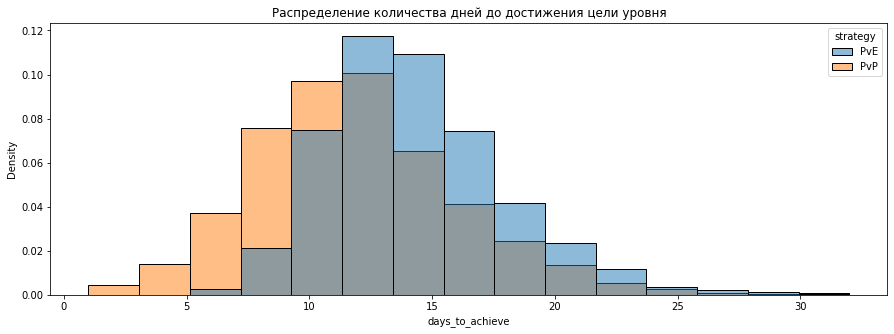

In [18]:
plt.figure(figsize=(15,5))
sns.histplot(data=users_for_test, x='days_to_achieve', hue='strategy', stat='density', common_norm=False, bins=15);
plt.title('Распределение количества дней до достижения цели уровня');

И показатель среднего, и гистограмма распределения дней до достижения цели уровня показывают определённые различия во времени этого достижения между двумя группами. Кроме того, распределения формой напоминают нормальное.

Выполним проверку гипотезы.

In [19]:
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(
    list(users_for_test.query("strategy=='PvE'")['days_to_achieve']), 
    list(users_for_test.query("strategy=='PvP'")['days_to_achieve']))

print(f"""Среднее время прохождение уровня в днях, PvE: {users_for_test.query("strategy=='PvE'")['days_to_achieve'].mean():.2f}""")
print(f"""Среднее время прохождение уровня в днях, PvP: {users_for_test.query("strategy=='PvP'")['days_to_achieve'].mean():.2f}""")
print(f'p-значение: {results.pvalue:.3f}')

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: среднее время прохождения уровня при PvE и PvP стратегиях отличается")
else:
    print("Не получилось отвергнуть нулевую гипотезу: среднее время прохождения уровня при PvE и PvP стратегиях не отличается") 

Среднее время прохождение уровня в днях, PvE: 14.40
Среднее время прохождение уровня в днях, PvP: 12.06
p-значение: 0.000
Отвергаем нулевую гипотезу: среднее время прохождения уровня при PvE и PvP стратегиях отличается


Игроки, ориентированные на PvP проходят уровень быстрее - вероятно, придётся поработать либо над балансом, либо над удержанием таких игроков.

Проверим ещё одну гипотезу: отличается ли количество построенных зданий у PvP и PvE-ориентированных игроков? Число построек важно, так как текущий план монетизации предусматривает показ рекламных объявлений при открытии меню строительства.

Сформулируем статистическую гипотезу:
* H0: Различий в среднем количестве построенных зданий между PvE- и PvP-ориентированными игроками нет.
* H1: Различия в среднем количестве построенных зданий между PvE- и PvP-ориентированными игроками есть.

Сравнивать будем **среднее** количество построенных данных, поэтому снова проведём t-тест.

Уровень значимости (a) снова установим равным `0.05`.

In [20]:
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(
    list(game_actions.query("user_id in @pvp_completers & event == 'building'").groupby('user_id')['event'].count()), 
    list(game_actions.query("user_id in @pve_completers & event == 'building'").groupby('user_id')['event'].count()))

print(f"""Среднее число построек на уровне, PvE: {game_actions.query("user_id in @pve_completers & event == 'building'").groupby('user_id')['event'].count().mean():.2f}""")
print(f"""Среднее число построек на уровне, PvP: {game_actions.query("user_id in @pvp_completers & event == 'building'").groupby('user_id')['event'].count().mean():.2f}""")
print(f'p-значение: {results.pvalue:.3f}')

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: среднее число построек при PvE и PvP стратегиях отличается")
else:
    print("Не получилось отвергнуть нулевую гипотезу: среднее число построек при PvE и PvP стратегиях не отличается") 

Среднее число построек на уровне, PvE: 12.65
Среднее число построек на уровне, PvP: 9.41
p-значение: 0.000
Отвергаем нулевую гипотезу: среднее число построек при PvE и PvP стратегиях отличается


Вполне ожидаемо PvP-ориентированные игроки менее склонны к строительству.

### Промежуточный вывод

На этом этапе проверили две гипотезы:
* Гипотеза о различии во времени прохождения уровня между PvP- и PvE-ориентированными игроками подтвердилась;
* Гипотеза о различии в количестве построек между PvP- и PvE-ориентированными игроками также подтвердилась.

Компании следует рассмотреть возможность внести изменения в баланс, чтобы сподвигнуть PvP-игроков больше строить и задержать их на уровне на более продолжительное время.

Можем перейти к разработки модели монетизации.

## Описание и оценка модели монетизации

На данный момент монетизация в игре не введена. Планируется показывать пользователю рекламу на экране строительства при выборе типа постройки.

Прибыль с одного показа рекламы - 0.07 условных единиц.

В первую очередь проработаем этот вариант - посмотрим, обеспечивает ли он окупаемость. 

Для этого:

    1) Для каждого пользователя посчитаем количество построек;
    2) Посчитаем прибыль с одного пользователя;
    3) Посчитаем разницу между прибылью и затратами на привлечение пользователя;
    4) Оценим окупаемость в целом, а также в подгруппах: PvE vs PvP, каналы привлечения.
    
Вне зависимости от того, обеспечивает ли изначальная стратегия окупаемость, рассмотрим альтернативные варианты.

In [21]:
users = users.merge(game_actions.pivot_table(index='user_id', values='building_type', aggfunc='count') \
                    .reset_index(), on='user_id').rename(columns={'building_type':'buildings'})

In [22]:
users['revenue'] = users['buildings'] * 0.07
users['profit'] = users['revenue'] - users['cost']
users

,user_id,source,reg_date,cost,target_achieved,date_target,strategy,buildings,revenue,profit
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads,2020-05-05,0.754162,False,NaT,undefined,13,0.91,0.155838
1,01303c2e-7de1-4742-8c3e-daf182b67b9f,facebook_ads,2020-05-05,0.754162,False,NaT,undefined,4,0.28,-0.474162
2,0136963c-c45c-4edb-92d8-205bd50a4d36,facebook_ads,2020-05-05,0.754162,True,2020-05-25 08:56:48,PvE,10,0.70,-0.054162
3,018793d6-38c8-450a-bd54-8c181d920f1a,facebook_ads,2020-05-05,0.754162,True,2020-05-24 23:52:53,PvE,12,0.84,0.085838
4,01e2b256-4519-493f-b010-4a90a2755245,facebook_ads,2020-05-05,0.754162,False,NaT,undefined,9,0.63,-0.124162
...,...,...,...,...,...,...,...,...,...,...
13571,f904bb06-e8f9-4aef-8773-5a47f12ac103,yandex_direct,2020-05-07,0.478784,False,NaT,undefined,5,0.35,-0.128784
13572,fa1ffc17-0032-4b4d-ac0d-6c75b890db9e,yandex_direct,2020-05-07,0.478784,True,2020-05-24 12:50:48,PvE,10,0.70,0.221216
13573,fd7d35ce-430b-40e0-a325-9d2b27b425e5,yandex_direct,2020-05-07,0.478784,True,2020-05-25 00:18:28,PvP,8,0.56,0.081216
13574,fec9a806-0291-4d46-914b-e4dd14ad3864,yandex_direct,2020-05-07,0.478784,False,NaT,undefined,10,0.70,0.221216


In [23]:
print(f"Общая прибыль при показе рекламы: {users['profit'].sum():.2f}")

Общая прибыль при показе рекламы: 1353.34


In [24]:
pd.concat([users.pivot_table(index='source', values='profit', aggfunc='sum'), 
          users.pivot_table(index='strategy', values='profit', aggfunc='sum')])

,profit
facebook_ads,-311.734643
instagram_new_adverts,65.608309
yandex_direct,919.128551
youtube_channel_reklama,680.340796
PvE,599.201983
PvP,397.817317
undefined,356.323714


В целом, рассматриваемая стратегия обеспечивает игре "Космические братья" окупаемость, но потенциально рекламная нагрузка в ней слишком велика.

У нас есть запас по прибыли - можем рассчитать дополнительные варианты монетизации, вплоть до чистого уровня окупаемости ("выхода в ноль").

In [25]:
print(f"В среднем пользователь строит {game_actions[game_actions['event']=='building'].groupby('user_id')['event'].count().mean():.0f} зданий.")
print(f"Средняя стоимость привлечения пользователя равна {users['cost'].mean():.2f} у.е. - столько необходимо получать с пользователя в среднем для достижения окупаемости.")
print(f"Общая стоимость привлечения пользователей составила {users['cost'].sum():.2f} у.е.")
print(f"Чтобы выйти на этот уровень необходимо в среднем показать {users['cost'].sum() / users['cost'].count() / 0.07:.0f} рекламных роликов.")

В среднем пользователь строит 9 зданий.
Средняя стоимость привлечения пользователя равна 0.56 у.е. - столько необходимо получать с пользователя в среднем для достижения окупаемости.
Общая стоимость привлечения пользователей составила 7603.58 у.е.
Чтобы выйти на этот уровень необходимо в среднем показать 8 рекламных роликов.


Запас по прибыли оказался небольшим - рассчитаем прибыль от продукта при условии показа рекламных роликов, начиная со второй постройки.

In [26]:
users_alt = users.copy()
users_alt['buildings'] = users_alt['buildings'] - 1 # уменьшаем количество показов рекламы
users_alt['buildings'].replace(-1, 0) # но отрицательного числа построек быть не может, поэтому заменяем -1 на 0
users_alt['revenue'] = users_alt['buildings'] * 0.07
users_alt['profit'] = users_alt['revenue'] - users_alt['cost']

print(f"Общая прибыль при альтернативной стратегии: {users_alt['profit'].sum():.2f}")

pd.concat([users_alt.pivot_table(index='source', values='profit', aggfunc='sum'), 
          users_alt.pivot_table(index='strategy', values='profit', aggfunc='sum')])

Общая прибыль при альтернативной стратегии: 403.02


,profit
facebook_ads,-502.554643
instagram_new_adverts,-168.681691
yandex_direct,581.938551
youtube_channel_reklama,492.320796
PvE,468.581983
PvP,121.247317
undefined,-186.806286


При альтернативной рекламной стратегии всё ещё окупаются вовлечённые игроки - выполнившие целевое действие, вне зависимости от собственной игровой стратегии. Однако те, кто не завершил первый уровень, перестают окупаться, аналогично перестаёт окупаться и Instagram как рекламная платформа.

Дальнейшее снижение рекламной нагрузки, вероятно, приведёт к потере окупаемости PvP-ориентированных игроков - что лишь усиливает рекомендацию скорректировать баланс игры.

Что, если снизить рекламную нагрузку ещё сильнее? Повторим те же манипуляции.

In [27]:
users_alt['buildings'] = users_alt['buildings'] - 1 # уменьшаем количество показов рекламы
users_alt['buildings'].replace(-1, 0) # но отрицательного числа построек быть не может, поэтому заменяем -1 на 0
users_alt['revenue'] = users_alt['buildings'] * 0.07
users_alt['profit'] = users_alt['revenue'] - users_alt['cost']

print(f"Общая прибыль при стратегии показа рекламы с третьего экрана постройки: {users_alt['profit'].sum():.2f}")

pd.concat([users_alt.pivot_table(index='source', values='profit', aggfunc='sum'), 
          users_alt.pivot_table(index='strategy', values='profit', aggfunc='sum')])

Общая прибыль при стратегии показа рекламы с третьего экрана постройки: -547.30


,profit
facebook_ads,-693.374643
instagram_new_adverts,-402.971691
yandex_direct,244.748551
youtube_channel_reklama,304.300796
PvE,337.961983
PvP,-155.322683
undefined,-729.936286


Как и ожидалось, PvP-игроки перестают окупаться, как перестаёт окупаться и игра в целом. Из позитивных моментов стоит отметить, что два канала привлечения всё ещё остаются прибыльными.

Выполним ещё одну - чисто гипотетическую - проверку: исключим "дорогие" каналы и проверим, насколько изменятся результаты второй альтернативной стратегии.

In [28]:
print(f"Общая прибыль при стратегии показа рекламы с третьего экрана постройки: {users_alt[users_alt['source'].isin(['yandex_direct', 'youtube_channel_reklama'])]['profit'].sum():.2f}")

pd.concat([users_alt[users_alt['source'].isin(['yandex_direct', 'youtube_channel_reklama'])].pivot_table(index='source', values='profit', aggfunc='sum'), 
          users_alt[users_alt['source'].isin(['yandex_direct', 'youtube_channel_reklama'])].pivot_table(index='strategy', values='profit', aggfunc='sum')])

Общая прибыль при стратегии показа рекламы с третьего экрана постройки: 549.05


,profit
yandex_direct,244.748551
youtube_channel_reklama,304.300796
PvE,303.379655
PvP,172.809728
undefined,72.859964


Без наиболее дорогих каналов игра остаётся на уровне окупаемости даже при условии показа рекламы начиная с третьей постройки - дополнительный аргумент в пользу перераспределения рекламных бюджетов.

### Промежуточный вывод

Рассматриваемая стратегия может быть признана успешной: она обеспечивает прибыль как в целом, так и в большинстве разрезов.

Единственное исключение - Facebook как источник трафика, привлечение пользователя в этом канале обходится слишком дорого при выбранной модели.

Рассмотрели также альтернативные варианты:

* При условии сохранения распределения рекламных бюджетов и неизменности баланса для PvP-игроков, стратегия показа рекламы начиная со второго экрана всё ещё обеспечивает окупаемость игры в целом, ценой окупаемости PvP-игроков и Instagram как источника трафика.

* При условии исключения наиболее дорогостоящих источников трафика, окупаемой является и стратегия показа рекламы начиная с третьего экрана строительства (неокупаемая в текущих условиях на всей выборке).

Подведём итоги.

## Общий вывод

За время работы над проектом установили несколько моментов:

* Существуют различия между PvP- и PvE-ориентированными игроками:
    - PvP-ориентированные игроки тратят меньше времени на прохождение первого уровня;
    - PvP-ориентированные игроки возводят меньше построек на уровне.
* Отток пользователей на первом уровне составляет около 60%;
* Предложенная модель монетизации обеспечивает прибыльность продукту в целом.

Говоря о модели монетизации, стоит отметить, что для одной из групп игроков модель не работает: привлечённые в Facebook пользователи слишком дороги и не окупаются.
Кроме того:
* Стратегия показа рекламы со второго экрана позволяет игре окупаться в состоянии "as is", без изменений в балансе и перераспределения маркетинговых бюджетов;
* При условии исключения наиболее дорогостоящих источников трафика, окупаемой является и стратегия показа рекламы начиная с третьего экрана строительства, не обеспечивающая окупаемости в данный момент.

Рекомендация для компании - пересмотреть баланс игры с целью усложнения PvP-компоненты, чтобы мотивировать игроков, придерживающихся этой стратегии, проводить в игре больше времени и возводить больше построек.

Кроме того, стоит отказаться от рекламы в Facebook - перераспределить бюджеты в пользу более прибыльных каналов (в первую очередь, яндекс.директ, затем - ютуб).